In [115]:
from sympy import *
init_printing()

In [117]:
from plot_setup import *
import model_definition as model
import seaborn as sns
#sns.set(style="ticks",palette="tab10")
sns.set_style('whitegrid')
sns.set_palette("tab10",10)
import matplotlib

#args_pairplot = {"size":5,"plot_kws":{"s":8,"marker":"o"},"diag_kws":{"bins":32,"histtype":"stepfilled","alpha":0.3}}
args_pairplot = {"plot_kws":{"s":8,"marker":"o"},"diag_kws":{"bins":32,"histtype":"stepfilled","alpha":0.3}}

def mypairplot(
    mcchain,
    scatter_kws={"s":1,"marker":"o","alpha":0.1},
    kde_kws={"shade":True,"shade_lowest":False,"cmap":"jet"},
    hist_kws={"bins":32,"histtype":"stepfilled","alpha":0.3},
    **kws):
    
    print("Note: The following warnings occur, but no problem.\nUserWarning: The following kwargs were not used by contour: 'label', 'color' ")
    g = sns.PairGrid(mcchain,**kws)
    g = g.map_upper(plt.scatter,**scatter_kws)
    g = g.map_lower(sns.kdeplot,**kde_kws)
    g = g.map_diag(plt.hist, **hist_kws)
    return g

In [199]:
r = symbols("r",positive=True)
R = symbols("R",positive=True)
v = symbols("v")
r_e= symbols(r"r_e",positive=True)
R_RoI = symbols(r"R_\text{RoI}",positive=True)

In [197]:
# definition of plummer model
plummer_2d = (1/pi/r_e**2)*(1+(R/r_e)**2)**(-2)
plummer_3d = (Rational(3,4)/pi/r_e**3)*(1+(r/r_e)**2)**(-Rational(5,2))

# Inverse transform sampling of Plummer distribution
If you have pdf $p(x)$, translate it to cdf $U(x) = \int_0^x dx' p(x')$. Then,

$x = U^{-1}(u)$ is the samples whose distribution is p(x) where $u \sim U(0,1)$ (uniform distribution) 

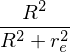

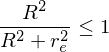

In [220]:
# U(x) for Plummer 
R1 = symbols(r"R'",positive=True)
Sigma = plummer_2d.subs(R,R1)
cdf = simplify(integrate(2*pi*R1*Sigma,(R1,0,R)))
# cdf : cummulated probability
display(cdf)
refine(cdf<=1,Q.positive(1-cdf))

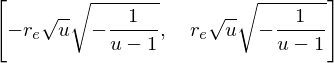

In [211]:
# U^{-1}(u) for Plummer 

u = symbols("u",positive = True)
assumptions.refine(u,Q.positive(1-u))
# solve(expr,var) : solve expr = 0 for var
inv_cdfs = solve(cdf-u, R)
display(u<=1)
display(inv_cdfs)

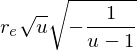

In [57]:
inv_cdf = inv_cdfs[1]
inv_cdf

In [113]:
# Member parameter and functions
r_e_obs = 100
v_mem = 50
sigma_los = lambda R: 10+10*(R/r_e_obs)
_generate_plummer_R_from_u = lambdify(u,inv_cdf.subs(r_e,r_e_obs),"numpy")
generate_plummer_R = lambda n: _generate_plummer_R_from_u(np.random.rand(n))

In [237]:
# create mock here
n_sample = 1000000
plummer_vRs = pd.DataFrame()
plummer_vRs["R"] = generate_plummer_R(n_sample)
plummer_vRs["v"] = np.random.normal(loc=v_mem,scale=sigma_los(plummer_vRs["R"]))
isin_RoI = lambda df: (df.R<100).values * (df.v<100).values * (0<df.v).values
#isin_RoI(plummer_vRs)
plummer_vRs_in_RoI = plummer_vRs[isin_RoI(plummer_vRs)]
display(plummer_vRs_in_RoI)
#mypairplot(plummer_vRs_in_RoI)

,R,v
2,64.440898,57.639890
3,84.411001,62.825128
4,46.363895,51.954907
7,88.233991,62.381797
8,70.506466,48.347471
9,80.289017,81.992453
10,76.185294,46.833847
12,22.906749,36.481640
18,65.294318,29.585342
19,85.004565,21.825587


In [228]:
# Foreground parameter and functions
v_fg = 200
dv_fg = 200
RoI_R_obs = 200
#_generate_uniform_R_from_u = lambdify(u,inv_cdf.subs(r_e,r_e_obs),"numpy")
generate_uniform_R = lambda n: np.random.triangular(size=n_sample,left=0,mode=RoI_R_obs,right=RoI_R_obs)

In [238]:
# create mock here
n_sample = 1000000
uniform_vRs = pd.DataFrame()
uniform_vRs["R"] = generate_uniform_R(n_sample)
uniform_vRs["v"] = np.random.normal(size=n_sample,loc=v_fg,scale=dv_fg)
isin_RoI = lambda df: (df.R<100).values * (df.v<100).values * (0<df.v).values
#isin_RoI(plummer_vRs)
uniform_vRs_in_RoI = uniform_vRs[isin_RoI(uniform_vRs)]
display(uniform_vRs_in_RoI)
#mypairplot(uniform_vRs_in_RoI)
#uniform_vRs.to_csv("mock_fg_"+specify_name+".csv")

,R,v
3,65.017657,65.060400
24,87.025471,42.592599
76,74.813912,70.321889
90,52.617250,2.683799
137,97.477318,96.216461
187,97.361491,82.391917
195,58.923347,87.991784
239,39.154605,79.708519
307,76.251312,10.072256
311,82.864194,46.199477


In [239]:
# output the files
specify_name = "noMCMC1milion_v001"
plummer_vRs.to_csv("mock_mem_"+specify_name+".csv")
uniform_vRs.to_csv("mock_fg_"+specify_name+".csv")